In [1]:
import pandas as pd
import json
import re
import numpy as np
from scipy.stats import circstd

In [2]:
#### LOAD DATA ####

In [3]:
def load_json_data(file_path):
    try:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON in file: {file_path}")
        return None
        
    return data

In [4]:
#### PROCESS DATA ###

In [5]:
def extract_sample_headings(data):
    extracted_data = []
    
    for packet in data:
        if ('tcp' in packet['_source']['layers'] and
            packet['_source']['layers']['ip']['ip.src'] == '10.1.4.15' and
            'data' in packet['_source']['layers'] and
            'data.text' in packet['_source']['layers']['data'] and
            'heading' in packet['_source']['layers']['data']['data.text']):
            
            heading_value = float(packet['_source']['layers']['data']['data.text'].split('\r\n')[1])
            time_delta = float(packet['_source']['layers']['frame']['frame.time_relative'])
            
            extracted_data.append({'Heading': heading_value, 'Time': time_delta})
    
    sample_headings = pd.DataFrame(extracted_data)
    return sample_headings

In [6]:
#### SANE DATA ####

In [7]:
# Load the filtered TCP packets from a normal scenario JSON file
training_file_patch = 'training_legit_heading_simple.json'
datalegit = load_json_data(training_file_patch)

sample_headings = extract_sample_headings(datalegit)
# Print the DataFrame
print(sample_headings)

    Heading        Time
0      12.3    0.320558
1      12.9    2.027415
2      13.2    2.847918
3      13.8    4.526987
4      14.2    5.532591
..      ...         ...
70     40.7   94.843383
71     39.9   96.606570
72     39.5   97.369310
73     38.6   99.210658
74     38.1  100.207307

[75 rows x 2 columns]


In [8]:
### SAVE DATA ###
# Write data in a JSON file
#with open('tcp_packets_print.json', 'w') as json_file:
#    json.dump(sample_headings, json_file, indent=4)  


In [9]:
## START OF THE ANALYSIS ##

In [109]:
# Define the window size for calculating standard deviation
window_size = 5
min_anomaly_window = 5  # Minimum number of consecutive anomalies to trigger an alert

In [110]:
print(type(sample_headings)) 

<class 'pandas.core.frame.DataFrame'>


In [111]:
# Calculate the standard deviation for each window of size window_size
max_std_dev = 0.0
for i in range(len(sample_headings) - window_size + 1):
    window = sample_headings['Heading'][i:i + window_size]
    std_dev = circstd(np.radians(window),  high=2*np.pi, low=0) 
    #print("window: ", window)
    #print("std_dev: ", std_dev)
    max_std_dev = max(max_std_dev, std_dev)
    #if (std_dev < 0.025):
    #    max_std_dev = max(max_std_dev, std_dev)

print(max_std_dev)

0.05075827696048929


In [112]:
# Set a threshold factor for anomaly detection
threshold_factor = 1.0

# Calculate the threshold based on the maximum standard deviation
threshold = threshold_factor * max_std_dev

# Print the calculated threshold
print("Threshold:", threshold)

Threshold: 0.05075827696048929


In [113]:
#### Data under-attack ####

In [114]:
# Load the filtered TCP packets from the under-attack JSON file
# training_attack_heading_simple --> full attack 100 sec
# tcp_packets_print --> 40-100 attack
# attaccodiverso
testing_file_patch = 'tcp_packets_print.json'
data_attack = load_json_data(testing_file_patch)

new_headings = extract_sample_headings(data_attack)
# Print the DataFrame
print(new_headings)

     Heading       Time
0        9.3   5.685901
1        9.4   8.653206
2        9.5  10.553324
3        9.6  11.541004
4        9.7  13.220355
..       ...        ...
128     45.0  98.343056
129     22.2  98.343460
130     45.0  98.440226
131     22.2  99.284434
132     45.0  99.353876

[133 rows x 2 columns]


In [115]:
## DETECTION LOOP ## 

In [131]:
anomaly_count = 0
anomalies = []


# Attack times
attack_start_time = 40 
attack_detected_time = None

for heading in range(len(new_headings) - window_size + 1):
    window = new_headings['Heading'][heading:heading + window_size]
    std_dev = circstd(np.radians(window), high=6.283185307179586, low=0)
    #print("window: ", window)
    #print("std_dev: ", std_dev)
    if std_dev > threshold:
        anomaly_count += 1
        if anomaly_count >= min_anomaly_window:
            anomalies.append(1)
            #print(anomalies)
            if attack_detected_time is None:
                attack_detected_time = new_headings['Time'][heading + window_size - 1]
        else:
            anomalies.append(0)
    else:
        anomalies.append(0)
        anomaly_count = 0

print(f"Attack start at time {attack_start_time:.2f} seconds")
if attack_detected_time is not None:
    time_to_detection = attack_detected_time - attack_start_time
    print(f"Attack detected at time {attack_detected_time:.2f} seconds")
    print(f"Time to detection: {time_to_detection:.2f} seconds")
else:
    print("No attack detected")

Attack start at time 40.00 seconds
Attack detected at time 42.43 seconds
Time to detection: 2.43 seconds


In [126]:
## PLOT ## 

In [127]:
print (anomalies)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


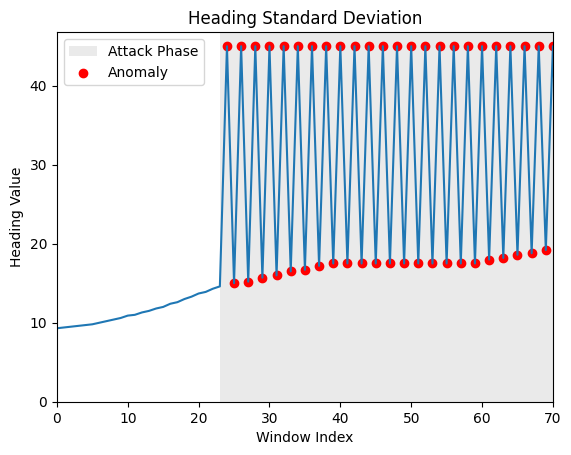

In [128]:
# Plot the heading values
import matplotlib.pyplot as plt
plt.plot(new_headings['Heading'])#, color='#ff7f0e')

# Add shaded area for attack phase
plt.axvspan(23, len(new_headings), facecolor=(50/255, 50/255, 50/255), alpha=0.1, label='Attack Phase')

anomaly_indices = np.flatnonzero(anomalies)

plt.scatter(anomaly_indices, new_headings['Heading'][anomaly_indices], c='red', label='Anomaly')

plt.xlabel('Window Index')
plt.ylabel('Heading Value')
plt.title('Heading Standard Deviation')

# Set y-axis lower limit to zero
plt.ylim(ymin=0)
#plt.xlim(xmin=0)

# Set custom x-axis limits for zoom
zoom_start = 0
zoom_end = 70
plt.xlim(xmin=zoom_start, xmax=zoom_end)

# Show the legend
plt.legend()
plt.show()

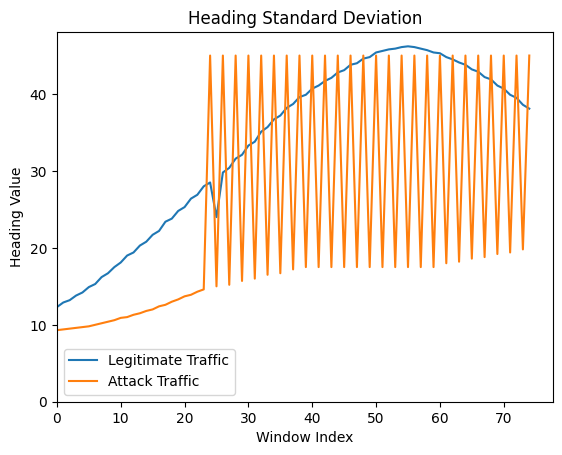

In [129]:
new_headings = new_headings[:len(sample_headings)]

plt.plot(sample_headings['Heading'], label='Legitimate Traffic')
plt.plot(new_headings['Heading'], label='Attack Traffic')

plt.xlabel('Window Index')
plt.ylabel('Heading Value')
plt.title('Heading Standard Deviation')

# Set y-axis lower limit to zero
plt.ylim(ymin=0)
plt.xlim(xmin=0)

# Add shaded area for attack phase
#plt.axvspan(23, len(new_headings), facecolor=(50/255, 50/255, 50/255), alpha=0.1, label='Attack Phase')


# Show the legend
plt.legend()
plt.show()

In [20]:
#######  EVALUATION  #######

In [21]:
benign_file_patch = 'training_legit_heading_simple.json'
malicious_file_patch = 'training_attack_heading_simple.json'

benign_json = load_json_data(benign_file_patch)
malicious_json = load_json_data(malicious_file_patch)

benign_training = extract_sample_headings(benign_json)
malicious_training = extract_sample_headings(malicious_json)



In [22]:
# Create overlap windows
benign_windows = [(benign_training['Heading'][i:i + window_size],0) for i in range(len(sample_headings) - window_size + 1)]

malicious_windows = [(malicious_training['Heading'][i:i + window_size],1) for i in range(len(new_headings) - window_size + 1)]

# Stampa le finestre
for window in malicious_windows:
    print(window)

(0    56.0
1    80.0
2    56.0
3    80.0
4    56.2
Name: Heading, dtype: float64, 1)
(1    80.0
2    56.0
3    80.0
4    56.2
5    80.0
Name: Heading, dtype: float64, 1)
(2    56.0
3    80.0
4    56.2
5    80.0
6    56.3
Name: Heading, dtype: float64, 1)
(3    80.0
4    56.2
5    80.0
6    56.3
7    80.0
Name: Heading, dtype: float64, 1)
(4    56.2
5    80.0
6    56.3
7    80.0
8    56.4
Name: Heading, dtype: float64, 1)
(5    80.0
6    56.3
7    80.0
8    56.4
9    80.0
Name: Heading, dtype: float64, 1)
(6     56.3
7     80.0
8     56.4
9     80.0
10    56.4
Name: Heading, dtype: float64, 1)
(7     80.0
8     56.4
9     80.0
10    56.4
11    80.0
Name: Heading, dtype: float64, 1)
(8     56.4
9     80.0
10    56.4
11    80.0
12    56.5
Name: Heading, dtype: float64, 1)
(9     80.0
10    56.4
11    80.0
12    56.5
13    80.0
Name: Heading, dtype: float64, 1)
(10    56.4
11    80.0
12    56.5
13    80.0
14    56.4
Name: Heading, dtype: float64, 1)
(11    80.0
12    56.5
13    80.0
14    

In [23]:
# Combine windows and labels into a single list
combined_windows = benign_windows + malicious_windows

# Print the result
for window, label in combined_windows:
    print(window)
    print("Label:", label)
    print()

0    12.3
1    12.9
2    13.2
3    13.8
4    14.2
Name: Heading, dtype: float64
Label: 0

1    12.9
2    13.2
3    13.8
4    14.2
5    14.9
Name: Heading, dtype: float64
Label: 0

2    13.2
3    13.8
4    14.2
5    14.9
6    15.3
Name: Heading, dtype: float64
Label: 0

3    13.8
4    14.2
5    14.9
6    15.3
7    16.2
Name: Heading, dtype: float64
Label: 0

4    14.2
5    14.9
6    15.3
7    16.2
8    16.7
Name: Heading, dtype: float64
Label: 0

5    14.9
6    15.3
7    16.2
8    16.7
9    17.5
Name: Heading, dtype: float64
Label: 0

6     15.3
7     16.2
8     16.7
9     17.5
10    18.1
Name: Heading, dtype: float64
Label: 0

7     16.2
8     16.7
9     17.5
10    18.1
11    19.0
Name: Heading, dtype: float64
Label: 0

8     16.7
9     17.5
10    18.1
11    19.0
12    19.4
Name: Heading, dtype: float64
Label: 0

9     17.5
10    18.1
11    19.0
12    19.4
13    20.3
Name: Heading, dtype: float64
Label: 0

10    18.1
11    19.0
12    19.4
13    20.3
14    20.8
Name: Heading, dtype: flo

In [24]:
anomaly_count = 0

# Attack times
attack_start_time = 40 
attack_detected_time = None

for heading in range(len(new_headings) - window_size + 1):
    window = new_headings['Heading'][heading:heading + window_size]
    std_dev = circstd(np.radians(window), high=6.283185307179586, low=0)
    
    if std_dev > threshold:
        anomaly_count += 1
        if anomaly_count >= min_anomaly_window and attack_detected_time is None:
            attack_detected_time = new_headings['Time'][heading + window_size - 1]
            #print(f"Heading: {new_headings['Heading'][heading]:.1f}")
            break
    else:
        anomaly_count = 0

print(f"Attack start at time {attack_start_time:.2f} seconds")
if attack_detected_time is not None:
    time_to_detection = attack_detected_time - attack_start_time
    print(f"Attack detected at time {attack_detected_time:.2f} seconds")
    print(f"Time to detection: {time_to_detection:.2f} seconds")
else:
    print("No attack detected")

Attack start at time 40.00 seconds
Attack detected at time 41.52 seconds
Time to detection: 1.52 seconds


In [25]:
result_labels=[]

for heading in range(len(combined_windows)):
    windows_subset = combined_windows[heading:heading + window_size]
    window_data = [window[0] for window in windows_subset]  # Extract window data from each tuple
    std_dev = circstd(np.radians(window_data[0]), high=2*np.pi, low=0)
    
    if std_dev >= threshold:
        result_labels.append(1)
        #print("ANOMALIA")
        #print([window_data[0], 1])
        #print("std_dev:", std_dev)
        #print("threshold:", threshold)
    else:
        result_labels.append(0)
        #print("APPOSTO")
        #print([window_data[0], 0])
        #print("std_dev:", std_dev)
        #print("threshold:", threshold)

# Print the evaluation results
print(result_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Extract labels from the list of tuples combined_windows
true_labels = [label for _, label in combined_windows]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, result_labels)
precision = precision_score(true_labels, result_labels)
recall = recall_score(true_labels, result_labels)
f1 = f1_score(true_labels, result_labels)

# print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.995
Precision: 0.9923076923076923
Recall: 1.0
F1-score: 0.9961389961389961


In [27]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, result_labels)

# Create a DataFrame from the confusion matrix
confusion_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

print(confusion_df)

                 Predicted Negative  Predicted Positive
Actual Negative                  70                   1
Actual Positive                   0                 129
